In [32]:
import matplotlib.pyplot as plt
import pandas as pd
from pandas.io.json import json_normalize
import numpy as np
import seaborn as sns
import matplotlib.dates as mdates
%matplotlib inline

### A: Exploratory analysis 

In [35]:
#import the text file and write it to another text file. 
import io
i = 0
with io.open('amazon.txt', 'w', encoding="utf8") as file:
    with io.open('amazon-meta.txt', 'r', encoding="utf8") as f:
        for line in f:
            line = line.strip()
            if line[:3] == 'Id:':
                id = int(line[4:])
                i += 1
            if line[:5] == 'ASIN:':
                asin = line[6:]
            if line[:6] == 'title:':
                title = line[7:].replace('"','').replace(',','')
            if line[:6] == 'group:':
                group = line[7:]
            if line[:8] == 'similar:':
                similar = int(line[9:11])
            if line[:11] == 'categories:':
                categories = (line[12:])
            if line[:8] == 'reviews:':
                reviews = int(line[15:18])
                avg_rating = float(line[-3:].replace(':',''))
                strwrite = str(id) + ',' + asin + ',"' + title + '",' + group + ',' +  str(similar) + ',' +  categories + ',' +  str(reviews) + ',' +  str(avg_rating)
                file.write(strwrite + '\n')
file.close

<function close>

In [36]:
df = pd.read_csv('amazon.txt', header=None, 
                 names=['id', 'asin', 'title', 'group', 'similar', 'categories', 'reviews', 'avg_rating'])

In [38]:
df.head(3)

,id,asin,title,group,similar,categories,reviews,avg_rating
0,1,0827229534,Patterns of Preaching: A Sermon Sampler,Book,5,2,2,5.0
1,2,0738700797,Candlemas: Feast of Flames,Book,5,2,12,4.5
2,3,0486287785,World War II Allied Fighter Planes Trading Cards,Book,0,1,1,5.0


In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 542684 entries, 0 to 542683
Data columns (total 8 columns):
id            542684 non-null int64
asin          542684 non-null object
title         542684 non-null object
group         542684 non-null object
similar       542684 non-null int64
categories    542684 non-null int64
reviews       542684 non-null int64
avg_rating    542684 non-null float64
dtypes: float64(1), int64(4), object(3)
memory usage: 33.1+ MB


There is no missing values in this data set and the format is good to feed into a choosen model. 

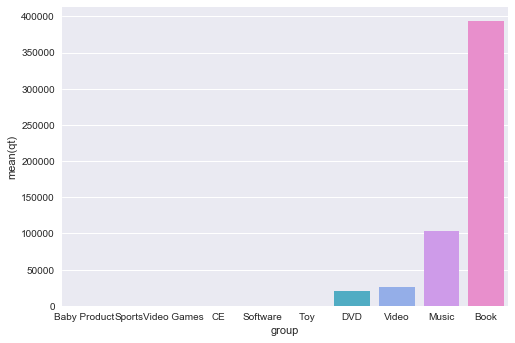

In [173]:
grouped = df.groupby('group').size().reset_index()
grouped.columns=['group', 'qt']
grouped= grouped.sort_values('qt')
grouped.loc[:, 'group']

s = sns.barplot(x=grouped.loc[:, 'group'], y=grouped.loc[:, 'qt'])

The barplot above shows the number of products by each group. Clearly, amazon at that time has most of products in books followed by music. The third and forth place are videos and DVD, respectively. 

### 1: Trustworthiness of ratings
The average_rating does show some inconsistency if we compare the reviews made on the product and the rating. In average, the rating will be very good even if the reviews is very small which makes the rating very unreliable. For example, at 75% quantile there is only 8 reviews but the rating is 5. 

In [146]:
df.describe()

,id,similar,categories,reviews,avg_rating
count,542684.000000,542684.000000,542684.000000,542684.000000,542684.000000
mean,274414.212208,3.296071,4.624605,7.498229,3.209534
std,158454.479276,2.287289,4.450647,13.759132,1.996296
min,1.000000,0.000000,0.000000,0.000000,0.000000
25%,137161.750000,0.000000,2.000000,0.000000,0.000000
50%,274427.500000,5.000000,4.000000,2.000000,4.000000
75%,411674.250000,5.000000,6.000000,8.000000,5.000000
max,548551.000000,5.000000,116.000000,99.000000,5.000000


In [179]:
#reviews and average rating by group
df.groupby('group').mean()[['reviews',"avg_rating"]]

,reviews,avg_rating
group,,
Baby Product,3.000000,4.500000
Book,6.347888,3.051148
CE,1.250000,1.750000
DVD,17.353994,3.670996
Music,8.411483,3.635529
Software,2.600000,4.500000
Sports,5.000000,4.000000
Toy,4.625000,3.812500
Video,13.743561,3.563105


According to the result above, the avg_rating has mean of 3.2 which is not so bad; within this Music, DVD and Videos has the similar average rating whereas book has sightly lower average rating. We're not talking about other groups as they contributes very small number in this data set. DVD and Videos seems to have more average reviews than other group. 

In [169]:
#Find items which have a lot of reviews and good ratings
df[(df.reviews>=99) & (df.avg_rating== 5.0)].sort_values('group')[['id','title', 'group']]

,id,title,group
35193,35596,Gentle Rogue (Malory Novels (Paperback)),Book
58125,58740,The China Garden,Book
326615,330380,Dice Angel,Book
60954,61614,Josh Groban,Music
80021,80871,Magazine,Music
263042,266042,The Shape of Punk to Come: A Chimerical Bombat...,Music
321975,325697,Let It Be,Music
498125,503823,Cool Relax,Music
498137,503835,Cool Relax,Music
508989,514817,Let It Be,Music


In [170]:
#Find items which have a lot of reviews and bad ratings
df[(df.reviews>=99) & (df.avg_rating<3.0)].sort_values('group')[['id','title', 'group']]

,id,title,group
190077,192156,The Elder Gods : Book One of the Dreamers (Dre...,Book
228560,231156,Full Tilt,Book
393821,398337,Full Tilt (Janet Evanovich's Full Series),Book
527508,533366,Speed 2 - Cruise Control,DVD
536433,542301,Speed 2 - Cruise Control,DVD
269468,272539,Speed 2 - Cruise Control,Video


In [171]:
#Display and write the categories of sample products
i, is_categories, is_group = 0, False, False
with io.open('amazon_categories.txt', 'w', encoding="utf8") as file:
    with io.open('amazon-meta.txt', 'r', encoding="utf8") as f:
        for line in f:
            line = line.strip()
            if i == 10:
                break
            if line[:6] == 'group:':
                #print ('group', (line[7:]))
                is_group = line[7:] == 'Book'
                j = 0
                is_categories = False
                i += 1
                
            if line[:11] == 'categories:' and group:
                #print ('categories', (line[12:]))
                num_categories = int(line[12:])
                is_categories = True
            
            if (is_categories and is_group and j <= num_categories):
                j += 1
                print (line)
                #strwrite = str(id) + ',' + asin + ',"' + title + '",' + group + ',' +  str(similar) + ',' +  categories + ',' +  str(reviews) + ',' +  str(avg_rating)
                #file.write(strwrite + '\n')
file.close

categories: 2
|Books[283155]|Subjects[1000]|Religion & Spirituality[22]|Christianity[12290]|Clergy[12360]|Preaching[12368]
|Books[283155]|Subjects[1000]|Religion & Spirituality[22]|Christianity[12290]|Clergy[12360]|Sermons[12370]
categories: 2
|Books[283155]|Subjects[1000]|Religion & Spirituality[22]|Earth-Based Religions[12472]|Wicca[12484]
|Books[283155]|Subjects[1000]|Religion & Spirituality[22]|Earth-Based Religions[12472]|Witchcraft[12486]
categories: 1
|Books[283155]|Subjects[1000]|Home & Garden[48]|Crafts & Hobbies[5126]|General[5144]
categories: 5
|Books[283155]|Subjects[1000]|Religion & Spirituality[22]|Christianity[12290]|Reference[172810]|Commentaries[12155]|New Testament[12159]
|Books[283155]|Subjects[1000]|Religion & Spirituality[22]|Christianity[12290]|Christian Living[12333]|Discipleship[12335]
|Books[283155]|Subjects[1000]|Religion & Spirituality[22]|Christianity[12290]|Bibles[12059]|Translations[764432]|Life Application[572080]
|Books[283155]|Subjects[1000]|Religion & 

<function close>

### 2: Category bloat
According to the result above, there are many reduancies in the categories. We can filter out the similar categories and rebuilt a classifier or clustering so that the categories can be reduced to a smaller number like 10%. It can be done using ML algorithm like naive bayes and SVM etc.

## B: Thinking
### 1. Algorithm thinking
To build the product categorization from scratch, one has to build a clustering algorithm to classify the category based on the similar/co-purchased information presented. One the clustering is successfully completed, we can look into the statistics and compute the category based on that. 

### 2. Product thinking
 
 a. It's a good idea to show users  the categorization hierarchy, but too much of hierarchy also can cause confusion and overloading to the users's comprehension. 
 
 b. It's a good idea to show users similar/co-purchased items. It can be like a recommendation system where users find its easier to purchase products that usually goes together. 
 
 c. It's a must for users to see the review and ratings because it gives the users the creditability of the products and other experiences on the products. 